In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import clone 


In [11]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [12]:
try:
    project_root = Path.cwd().parent
    features_path = project_root / "data" / "processed" / "features_regresion.csv"
    df_reg = pd.read_csv(features_path)
    print(f"DataFrame para regresión cargado desde: {features_path}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en: {features_path}")
    df_reg = None

DataFrame para regresión cargado desde: /Users/edusant/Desktop/personal/blue_tab/proyecto-riesgo-crediticio/data/processed/features_regresion.csv


In [ ]:
def train_and_evaluate_regressor(X_train, y_train, X_test, y_test, model, model_name, use_log_transform=False):
    """
    Entrena un modelo de regresión, realiza predicciones y devuelve las métricas y artefactos.
    """
    feature_names = X_train.columns.tolist()
    
    # Aplicar transformación logarítmica si se especifica
    y_train_target = y_train
    if use_log_transform:
        y_train_target = np.log1p(y_train)

    model.fit(X_train, y_train_target)
    
    y_pred = model.predict(X_test)
    
    # Transformación inversa si es necesario
    if use_log_transform:
        y_pred = np.expm1(y_pred)
    
    # Cálculo de métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    transform_label = "Con Log" if use_log_transform else "Sin Log"
    print(f"\n--- Resultados para {model_name} ({transform_label}) ---")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    metrics = {
        'Model': model_name,
        'Transformation': transform_label,
        'R2 Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'artifacts': {
            'model': model,
            'feature_names': feature_names
        }
    }
    
    return metrics, y_pred

In [14]:
if df_reg is not None:
    # 1. División Temporal de Datos
    df_reg_sorted = df_reg.sort_values('ID').reset_index(drop=True)
    split_point = int(len(df_reg_sorted) * 0.8)
    train_df = df_reg_sorted.iloc[:split_point]
    test_df = df_reg_sorted.iloc[split_point:]

    # 2. Definir X e y, excluyendo el ID de las características
    target_col = 'pay_amt_june'
    features_to_use = df_reg.select_dtypes(include=np.number).columns.drop([target_col, 'ID'], errors='ignore').tolist()
    
    X_train = train_df[features_to_use]
    y_train = train_df[target_col]
    X_test = test_df[features_to_use]
    y_test = test_df[target_col]

    # 3. Escalado de Características (se pasa un DataFrame con nombres de columnas)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features_to_use)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features_to_use)

    # 4. Definir Prototipos de Modelos
    model_prototypes = {
        "Regresión Lineal": LinearRegression(),
        "Regresión de Huber": HuberRegressor(max_iter=1000),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    }
    
    results = []
    predictions = {}

    # 5. Iterar, Clonar y Entrenar
    for name, model_proto in model_prototypes.items():
        # Experimento SIN transformación logarítmica
        model_no_log = clone(model_proto)
        metrics_no_log, y_pred_no_log = train_and_evaluate_regressor(X_train_scaled, y_train, X_test_scaled, y_test, model_no_log, name, use_log_transform=False)
        results.append(metrics_no_log)
        predictions[f"{name} (Sin Log)"] = y_pred_no_log
        
        # Experimento CON transformación logarítmica
        model_log = clone(model_proto)
        metrics_log, y_pred_log = train_and_evaluate_regressor(X_train_scaled, y_train, X_test_scaled, y_test, model_log, name, use_log_transform=True)
        results.append(metrics_log)
        predictions[f"{name} (Con Log)"] = y_pred_log

    # 6. Tabla Comparativa de Resultados
    results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
    
    print("\n--- Tabla Comparativa de Rendimiento de Modelos de Regresión ---")
    display(results_df.drop(columns=['artifacts']))



--- Resultados para Regresión Lineal (Sin Log) ---
R² Score: 0.4166
RMSE: 14103.3570
MAE: 5610.7247

--- Resultados para Regresión Lineal (Con Log) ---
R² Score: -62641888236840977170432.0000
RMSE: 4621481861457583.0000
MAE: 59663076810113.8047

--- Resultados para Regresión de Huber (Sin Log) ---
R² Score: 0.1818
RMSE: 16701.9439
MAE: 3814.3544

--- Resultados para Regresión de Huber (Con Log) ---
R² Score: -87274689794873428541440.0000
RMSE: 5454977826492116.0000
MAE: 70423465353051.4844

--- Resultados para Random Forest (Sin Log) ---
R² Score: 0.6283
RMSE: 11257.3436
MAE: 1975.7684

--- Resultados para Random Forest (Con Log) ---
R² Score: 0.6716
RMSE: 10581.4010
MAE: 1700.2837

--- Resultados para XGBoost (Sin Log) ---
R² Score: 0.6437
RMSE: 11021.4729
MAE: 2090.2957

--- Resultados para XGBoost (Con Log) ---
R² Score: 0.6015
RMSE: 11656.5799
MAE: 2249.6873

--- Tabla Comparativa de Rendimiento de Modelos de Regresión ---


,Model,Transformation,R2 Score,RMSE,MAE
5,Random Forest,Con Log,6.716109e-01,1.058140e+04,1.700284e+03
6,XGBoost,Sin Log,6.437280e-01,1.102147e+04,2.090296e+03
4,Random Forest,Sin Log,6.283157e-01,1.125734e+04,1.975768e+03
7,XGBoost,Con Log,6.014850e-01,1.165658e+04,2.249687e+03
0,Regresión Lineal,Sin Log,4.166256e-01,1.410336e+04,5.610725e+03
2,Regresión de Huber,Sin Log,1.818435e-01,1.670194e+04,3.814354e+03
1,Regresión Lineal,Con Log,-6.264189e+22,4.621482e+15,5.966308e+13
3,Regresión de Huber,Con Log,-8.727469e+22,5.454978e+15,7.042347e+13



--- Análisis Profundo del Mejor Modelo: Random Forest (Con Log) ---


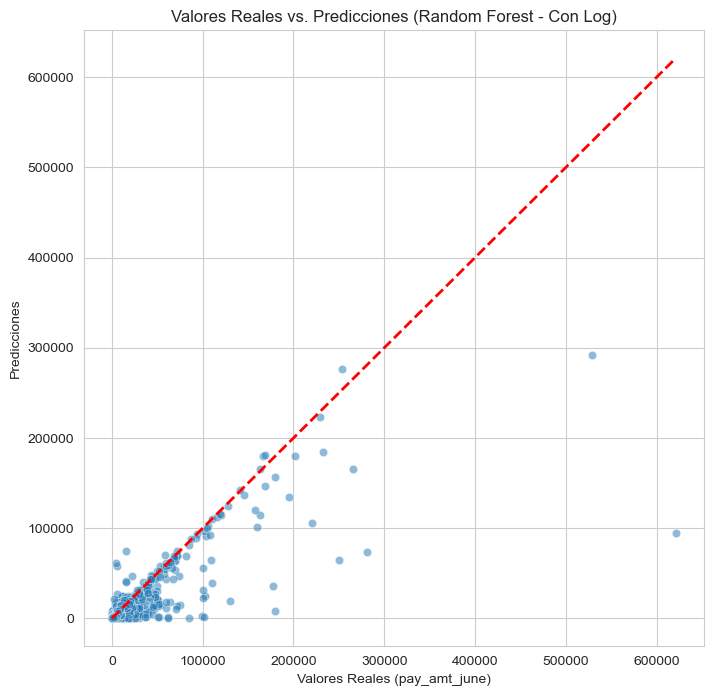

/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_46035/630328419.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


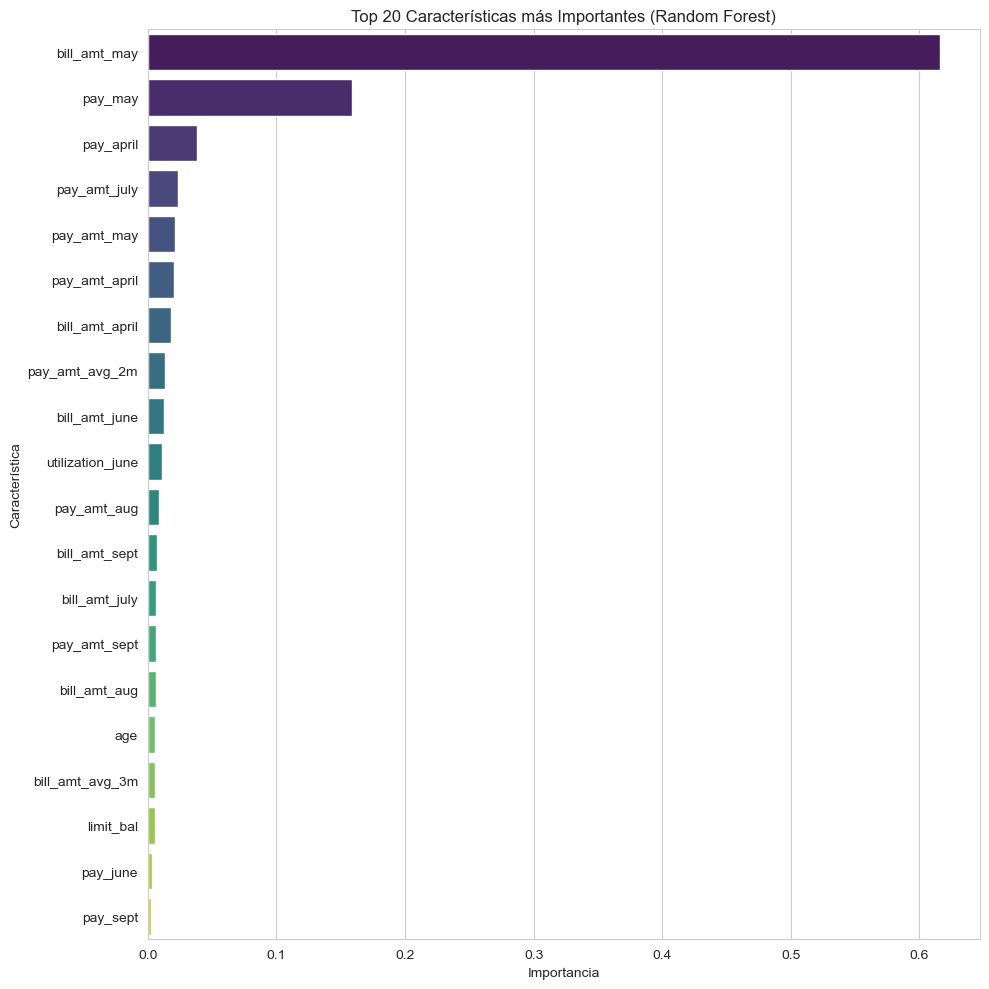

In [15]:
if 'results_df' in locals() and not results_df.empty:
    best_row = results_df.loc[results_df['R2 Score'].idxmax()]
    best_model_name = best_row['Model']
    best_transform_label = best_row['Transformation']
    best_prediction_key = f"{best_model_name} ({best_transform_label})"
    
    print(f"\n--- Análisis Profundo del Mejor Modelo: {best_model_name} ({best_transform_label}) ---")
    
    # 1. Gráfico de Predicciones vs. Valores Reales
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=predictions[best_prediction_key], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.title(f'Valores Reales vs. Predicciones ({best_model_name} - {best_transform_label})')
    plt.xlabel('Valores Reales (pay_amt_june)')
    plt.ylabel('Predicciones')
    plt.show()
    
    # 2. Importancia de Características (usando artefactos)
    artifacts = best_row['artifacts']
    best_model_instance = artifacts['model']
    feature_names = artifacts['feature_names']

    if hasattr(best_model_instance, 'feature_importances_'):
        importances = best_model_instance.feature_importances_
        
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(10, 10))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
        plt.title(f'Top 20 Características más Importantes ({best_model_name})')
        plt.xlabel('Importancia')
        plt.ylabel('Característica')
        plt.tight_layout()
        plt.show()